In [1]:
import numpy as np
from scipy import spatial, optimize
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.pylab as plt
import os
from scipy import spatial
from sklearn.decomposition import PCA

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fpn5gmj_ because the default path (/home/agitated_curran/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class GPregressor :
    def __init__(self, Input_dim, Nb_points, kernel):
        """Initializing the GPR parameters :
            Inputs : 
                - Input_dim : the dimentionality of the input 
                - Nb_points : the number of points in the training dataset
                - kernel : the covariance function it will use
        """
        self.dim_i = Input_dim
        self.Nb = Nb_points
        self.kernel = kernel
        self.Cov_mat = []

    def unmake_xy(self, hand):
        """Function : Unflattens a shape that has 1D vector format to 3D fromat
        Inputs : 
             - shape : vector of concatenated point's coordinates 
        Output :
             - Shape_3d : list of the 3D points of the shape
        """
        return np.vstack([hand[range(0, len(hand), 3)], hand[range(1, len(hand), 3)], hand[range(2, len(hand), 3)]]).T

    def make_xy(self, hand) :
        """Function : Flattens a shape that has 3D vector format to 1D format
        Inputs : 
             - Shape_3d : list of the 3D points of the shape
        Output :
             - shape : vector of concatenated point's coordinates 
             
        """
        return hand.flatten()

    def Cov_func(self, Points):
        """Function : Computes the reduced covariance matrix given a list of points using the specified kernel"""
        #kernel = 1.0 * Matern(length_scale=l, nu=n)+ ConstantKernel()+ WhiteKernel(noise_level=0.001)
        return self.kernel(Points)

    def fit(self, Training_shapes) :

        """Function : Train the model on multiple Training shapes 
            Inputs : 
                - Training_shapes : list of all the shapes in the train dataset
            Outputs :
                - Updates the GPR covariance matrix 
        """

        ## Initializing the reduced cov matrix
        Reduced_cov = np.zeros((self.Nb, self.Nb))
        for i in range(len(Training_shapes)) :
            # Computing the reduced covariance matrix for each shape deformation in the training set
            Reduced_cov += self.Cov_func(self.unmake_xy(Training_shapes[i, :]))

        Reduced_cov /= len(Training_shapes)

        # Computing the covariance matrix from the reduced form 
        Cov_matrix = np.zeros((self.dim_i*Reduced_cov.shape[0], self.dim_i*Reduced_cov.shape[0]))
        for i in range(self.Nb):
            for j in range(self.Nb) :
                Cov_matrix[self.dim_i*i:self.dim_i*(i+1), self.dim_i*j:self.dim_i*(j+1)] = Reduced_cov[i, j]*np.eye(self.dim_i)
        
        self.Cov_mat = Cov_matrix

    def predict(self, Incomplete_shape, Indexes) :
        """Function : Predicts the missing regions of an incompete mesh
            Inputs : 
                - Incomplete_shape : a flat vector representing the mesh 
                - Indexes : list of the missing points Indexes
            Outputs :
                - Zipped_data : return the complete input shape by filling the missing nodes 
        """

        # Defining the set of observed deformation 
        observed_points = Incomplete_shape[Indexes==1]

        # Defining the blocks of covariance matrix 
        Kxy = self.Cov_mat[Indexes==0, :][:, Indexes==1]
        Kyy = self.Cov_mat[Indexes==1, :][:, Indexes==1]

        # Computing the posterior mean shape
        Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

        # Combining the predicted deformations with the observed ones 
        Zipped_data = np.zeros(Incomplete_shape.shape)
        Zipped_data[Indexes==0] = Predicted_points
        Zipped_data[Indexes==1] = observed_points

        return Zipped_data

In [3]:
from tools.tools_constants import (
    PATH_DATASET,
    DELAY_FEATURE
)
from tools.tools_database import (
    read_data, 
    remove_outliers, 
    load_coords
)
from tools.tools_preprocessing import (
    coords_encoding
)

In [4]:
dataset = read_data(PATH_DATASET)


score_threshold = 3
dataset = remove_outliers(dataset, score_threshold)
dataset.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [5]:
colonnes = ['gare_depart',	'gare_arrivee']
L = load_coords(path='./Data/Coords.pickle')
gare_depart_coord_x = []
gare_depart_coord_y = []
gare_arrivee_coord_x = []
gare_arrivee_coord_y = []

# print(len(dataset[colonnes[0]]))
for j in range(len(dataset[colonnes[0]])):
    # print(j, dataset.iloc[j][colonnes[0]])
    gare_depart_coord_x.append(L[dataset.iloc[j][colonnes[0]]][0])
    gare_depart_coord_y.append(L[dataset.iloc[j][colonnes[0]]][1])
    gare_arrivee_coord_x.append(L[dataset.iloc[j][colonnes[1]]][0])
    gare_arrivee_coord_y.append(L[dataset.iloc[j][colonnes[1]]][1])

dataset['gare_depart_coord_x'] = gare_depart_coord_x
dataset['gare_depart_coord_y'] = gare_depart_coord_y
dataset['gare_arrivee_coord_x'] = gare_arrivee_coord_x
dataset['gare_arrivee_coord_y'] = gare_arrivee_coord_y
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year

In [6]:
last_month_delay = []
last_month_causes = []
causes_cols = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']

n = 0
for j in range(len(dataset['date'])) :
    Row = dataset.iloc[j]
    Frame = dataset[dataset['gare_depart']==Row['gare_depart']]# & dataset['gare_arrivee']==Row['gare_arrivee']]
    Frame = Frame[Frame['gare_arrivee']==Row['gare_arrivee']]
    L = np.where(Frame["date"] == Row['date'])[0][0]
    if L>0 : 
        last_month_delay.append(Frame.iloc[L-1]['retard_moyen_arrivee'])
        last_month_causes.append(np.array(Frame.iloc[L-1][causes_cols]))
    else : 
        last_month_delay.append(0)
        last_month_causes.append(np.array([0, 0, 0, 0, 0, 0]))
        n += 1 

last_month_causes = np.array(last_month_causes)

dataset['retard_mois_prec'] = last_month_delay

for i in range(6) :
    dataset[f'cause{i}'] = last_month_causes[:, i]
dataset.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,gare_arrivee_coord_y,month,year,retard_mois_prec,cause0,cause1,cause2,cause3,cause4,cause5
0,2018-01-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,2.3200,1,2018,0.0,0,0,0,0,0,0
1,2018-01-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,2.3200,1,2018,0.0,0,0,0,0,0,0
2,2018-01-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,-4.0984,1,2018,0.0,0,0,0,0,0,0
3,2018-01-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,-2.0116,1,2018,0.0,0,0,0,0,0,0
4,2018-01-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,0.7234,1,2018,0.0,0,0,0,0,0,0


In [7]:
dataset = dataset[dataset['retard_mois_prec']!=0]
dataset = dataset[dataset['retard_moyen_arrivee']!=0]
gare_dataset = dataset[['gare_depart', 'gare_arrivee']]

In [8]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['gare_depart', 'gare_arrivee'])
dataset = encoder.fit_transform(dataset)
dataset.columns

Index(['date', 'service', 'gare_depart_0', 'gare_depart_1', 'gare_depart_2',
       'gare_depart_3', 'gare_depart_4', 'gare_depart_5', 'gare_arrivee_0',
       'gare_arrivee_1', 'gare_arrivee_2', 'gare_arrivee_3', 'gare_arrivee_4',
       'gare_arrivee_5', 'duree_moyenne', 'nb_train_prevu', 'nb_annulation',
       'commentaire_annulation', 'nb_train_depart_retard',
       'retard_moyen_depart', 'retard_moyen_tous_trains_depart',
       'commentaire_retards_depart', 'nb_train_retard_arrivee',
       'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee',
       'commentaires_retard_arrivee', 'nb_train_retard_sup_15',
       'retard_moyen_trains_retard_sup15', 'nb_train_retard_sup_30',
       'nb_train_retard_sup_60', 'prct_cause_externe', 'prct_cause_infra',
       'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',
       'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs',
       'gare_depart_coord_x', 'gare_depart_coord_y', 'gare_arrivee_coord_x',
       'ga

In [23]:
Features = ['gare_depart_coord_x', 'gare_depart_coord_y', 'gare_arrivee_coord_x',
       'gare_arrivee_coord_y', 'nb_train_prevu', 'month', 'year', 'retard_mois_prec', 'duree_moyenne', 'cause0']

Output = ['retard_moyen_arrivee', 'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs']

In [24]:
X_train, y_train = dataset[dataset['date'].dt.year != 2023][Features], dataset[dataset['date'].dt.year != 2023][Output]
X_test, y_test = dataset[dataset['date'].dt.year == 2023][Features], dataset[dataset['date'].dt.year == 2023][Output]

In [25]:
X_train.head()

,gare_depart_coord_x,gare_depart_coord_y,gare_arrivee_coord_x,gare_arrivee_coord_y,nb_train_prevu,month,year,retard_mois_prec,duree_moyenne,cause0
130,48.0785,-0.7698,48.8406,2.3200,187,2,2018,16.569091,86,16.129032
131,48.8406,2.3200,47.4633,-0.5485,351,2,2018,19.843590,90,21.428571
132,48.8406,2.3200,48.0061,0.1996,401,2,2018,16.904615,55,28.947368
133,48.8406,2.3200,46.5802,0.3403,459,2,2018,13.484936,93,26.923077
134,48.8406,2.3200,48.6475,-2.0116,92,2,2018,48.623077,154,23.076923


In [26]:
y_train.head()

,retard_moyen_arrivee,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
130,24.211429,27,10.049908,15,7,50.000000,18.000000,22.000000,4.000000,2.000000,4.000000
131,45.053810,49,10.666864,31,15,68.253968,15.873016,3.174603,7.936508,4.761905,0.000000
132,34.434211,51,8.787275,26,12,68.750000,13.750000,10.000000,5.000000,2.500000,0.000000
133,38.983010,78,11.088864,48,19,52.380952,15.476190,14.285714,13.095238,3.571429,1.190476
134,54.186111,15,11.410300,10,5,55.555556,16.666667,5.555556,22.222222,0.000000,0.000000


In [27]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_train = np.array(scaler.fit_transform(X_train))
# X_test = np.array(scaler.transform(X_test))

X_train, X_test = np.array(X_train), np.array(X_test)

y_train, y_test = np.array(y_train), np.array(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6915, 10), (6915, 11), (715, 10), (715, 11))

In [28]:
Train_stations = []
for i in range(len(X_train)) :
    Train_stations.append(dataset.iloc[i]['nb_train_prevu'])


S = np.unique(Train_stations)
Train_stations = np.array(Train_stations)

for i in range(len(S)) :
    Train_stations[Train_stations==S[i]] = i

Train_stations = Train_stations.astype(int)

In [29]:
from sklearn import ensemble
from sklearn.metrics import r2_score, mean_squared_error

params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train[:, 0].ravel())

y_pred = reg.predict(X_test)
r2_score(y_test[:, 0].ravel(), y_pred), mean_squared_error(y_test[:, 0].ravel(), y_pred)

(0.36446514404924846, 111.05076753721902)

In [30]:
# y_pred = reg.predict(X_train)
# r2_score(y_train[:, 0].ravel(), y_pred), mean_squared_error(y_train[:, 0].ravel(), y_pred)

In [31]:
from sklearn.ensemble import RandomForestRegressor

regr2 = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=600)
regr2.fit(X_train, y_train[:, 0].ravel())

y_pred = regr2.predict(X_test)
r2_score(y_test[:, 0].ravel(), y_pred), mean_squared_error(y_test[:, 0].ravel(), y_pred)

(0.3021098846637047, 121.94647113224512)

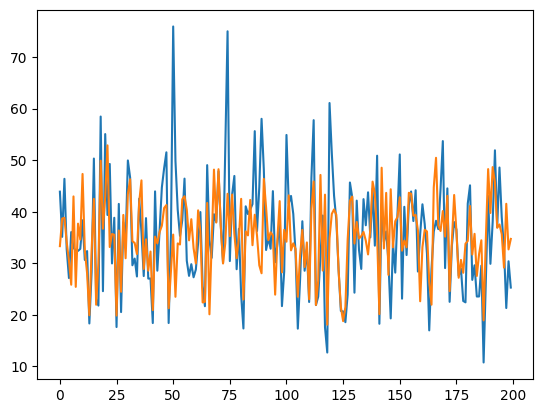

In [32]:
plt.plot(np.array([y_test[:, 0][:200]]).T)
plt.plot(reg.predict(X_test)[:200]) #, np.array([y_test[:, 0]]).T

plt.show()

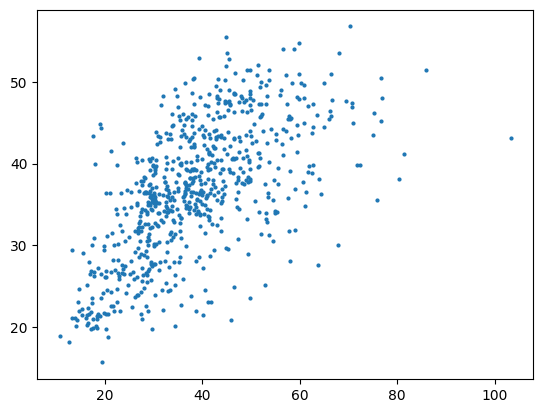

In [41]:
plt.scatter(y_test[:, 0], reg.predict(X_test), s=4)
plt.show()

In [33]:
# Test_frame = gare_dataset[dataset['date'].dt.year == 2023]

# for i in range(20) : 
#     Indexes = set(np.where(Test_frame['gare_depart']==Test_frame.iloc[i]['gare_depart'])[0]).intersection(set(np.where(Test_frame['gare_arrivee']==Test_frame.iloc[i]['gare_arrivee'])[0]))

#     Y1p = y_pred[list(Indexes)]
#     Y1r = np.array([y_test[list(Indexes), 0]]).T

#     plt.figure(figsize=(4,4))
#     plt.plot(Y1p, label="Predicted")
#     plt.plot(Y1r, label="Real")
#     plt.show()

In [34]:
dataset[['cause0', 'cause1', 'cause2', 'cause3', 'cause4', 'cause5']] = np.array(dataset[['cause0', 'cause1', 'cause2', 'cause3', 'cause4', 'cause5']]).astype(float)

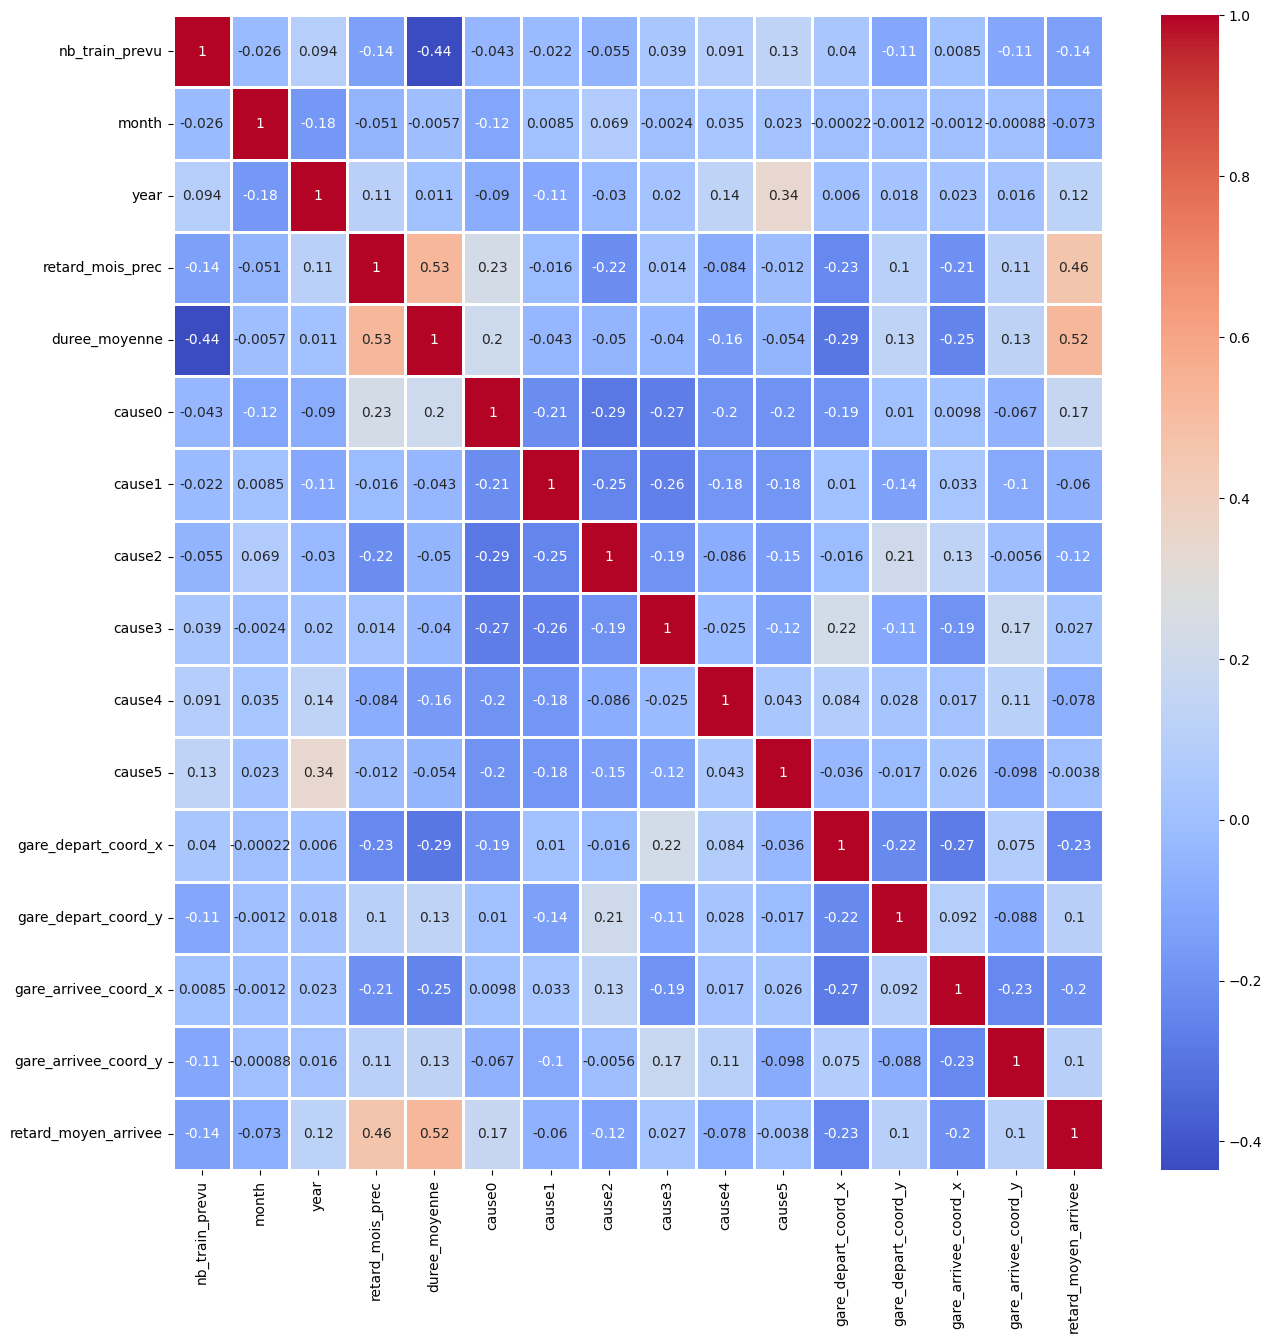

In [35]:
import seaborn as sn

correlation = dataset[['nb_train_prevu', 'month', 'year', 'retard_mois_prec', 'duree_moyenne', 'cause0', 'cause1', 'cause2', 'cause3', 'cause4', 'cause5', 'gare_depart_coord_x', 'gare_depart_coord_y', 'gare_arrivee_coord_x', 'gare_arrivee_coord_y', 'retard_moyen_arrivee']].corr()

plt.figure(figsize=(15, 15))
sn.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=1)
plt.show()

In [51]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, np.array([y_train[:, 0]]).T)
y_pred = neigh.predict(X_test)



r2_score(y_test[:, 0].ravel(), y_pred), mean_squared_error(y_test[:, 0].ravel(), y_pred)

(0.22439586786738586, 135.5259013284393)